In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Connect to the database and import the table 'Fires'
import os
import sqlite3

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


conn = sqlite3.connect('/kaggle/input/us-wildfire-records-6th-edition/data.sqlite') 
df = pd.read_sql_query('SELECT * FROM Fires;', con=conn)

# Close connection
conn.close()

# Quick overview of columns
df.info()

/kaggle/input/us-wildfire-records-6th-edition/_variable_descriptions.csv
/kaggle/input/us-wildfire-records-6th-edition/data.sqlite
/kaggle/input/us-wildfire-records-6th-edition/data.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2303566 entries, 0 to 2303565
Data columns (total 39 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   OBJECTID                       int64  
 1   Shape                          object 
 2   FOD_ID                         int64  
 3   FPA_ID                         object 
 4   SOURCE_SYSTEM_TYPE             object 
 5   SOURCE_SYSTEM                  object 
 6   NWCG_REPORTING_AGENCY          object 
 7   NWCG_REPORTING_UNIT_ID         object 
 8   NWCG_REPORTING_UNIT_NAME       object 
 9   SOURCE_REPORTING_UNIT          object 
 10  SOURCE_REPORTING_UNIT_NAME     object 
 11  LOCAL_FIRE_REPORT_ID           object 
 12  LOCAL_INCIDENT_ID              object 
 13  FIRE_CODE                      objec

The dataset contains numerous columns without interest for our analysis, we keep only those that deserve our objectives.

In [2]:
# Select only columns of interest
col_of_interest = ['OBJECTID', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'NWCG_GENERAL_CAUSE', 'CONT_DATE', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE' , 'LONGITUDE' , 'STATE']
df = df[col_of_interest].set_index('OBJECTID', verify_integrity = True)

# Let's rename the columns and the index for more clarity
df = df.rename(columns = {'FIRE_YEAR':'fire_year',
                         'DISCOVERY_DATE':'disc_date',
                         'DISCOVERY_DOY':'disc_doy',
                         'DISCOVERY_TIME' : 'disc_time',
                         'NWCG_GENERAL_CAUSE':'cause',
                         'CONT_DATE':'cont_date',
                         'CONT_TIME':'cont_time',
                         'FIRE_SIZE' : 'fire_size',
                         'FIRE_SIZE_CLASS' : 'fire_class',
                         'LATITUDE':'latitude',
                         'LONGITUDE':'longitude',
                         'STATE':'state'}).rename_axis('id')

# Let's convert the columns 'disc_date' and 'cont_date' in datetime format and add a colmun with the month
df['disc_date'] = pd.to_datetime(pd.to_datetime(df['disc_date'], format = '%m/%d/%Y').dt.strftime('%Y-%m-%d'))
df['cont_date'] = pd.to_datetime(pd.to_datetime(df['cont_date'], format = '%m/%d/%Y').dt.strftime('%Y-%m-%d'))
df.insert(3, 'disc_month', df['disc_date'].dt.month)
df.insert(4, 'disc_day', df['disc_date'].dt.day_name())

df.head()

,fire_year,disc_date,disc_doy,disc_month,disc_day,disc_time,cause,cont_date,cont_time,fire_size,fire_class,latitude,longitude,state
id,,,,,,,,,,,,,,
1,2005,2005-02-02,33,2,Wednesday,1300,Power generation/transmission/distribution,2005-02-02,1730,0.10,A,40.036944,-121.005833,CA
2,2004,2004-05-12,133,5,Wednesday,0845,Natural,2004-05-12,1530,0.25,A,38.933056,-120.404444,CA
3,2004,2004-05-31,152,5,Monday,1921,Debris and open burning,2004-05-31,2024,0.10,A,38.984167,-120.735556,CA
4,2004,2004-06-28,180,6,Monday,1600,Natural,2004-07-03,1400,0.10,A,38.559167,-119.913333,CA
5,2004,2004-06-28,180,6,Monday,1600,Natural,2004-07-03,1200,0.10,A,38.559167,-119.933056,CA


Let's chek if letter in 'fire_class' matches well values from 'fire_size' according to data source.

In [3]:
# Create our own classes, based on the paper from Short (2014)
df['fire_class_check'] = pd.cut(x=df['fire_size'], 
                                bins=[0, 0.25, 9.9999, 99.9999, 299.9999, 999.9999, 4999.9999, np.inf], 
                                include_lowest=True, 
                                labels=['A', 'B', 'C', 'D', 'E', 'F', 'G'])

# Check if letters in the original dataset match with our classes
for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
  print("Wrong match for category", letter, "=", df.loc[(df['fire_class_check'] != df['fire_class']) & (df['fire_class'] == letter)].shape[0])

Wrong match for category A = 0
Wrong match for category B = 0
Wrong match for category C = 0
Wrong match for category D = 0
Wrong match for category E = 0
Wrong match for category F = 0
Wrong match for category G = 0


Matches are all ok, we can remove the fire_class_check column.

In [4]:
df.drop('fire_class_check', axis = 1, inplace = True)

Let's define a function that will provide us some basics informations on the dataset, such as missing values, mode, mean, format of the variables.

In [5]:
def summary(df):
    '''This function allows to provide an overview of a dataset including missing values, mode or mean, format of the variables, number of unique values and alerts.'''
    table = pd.DataFrame(index = df.columns,
                        columns = ['Dtype', '%NA', 'nbr_unique', 'Unique', 'Mean/Mode', 'Alert'])
    table.loc[:,'Dtype'] = df.dtypes.values
    table.loc[:,'%NA'] = np.round((df.isna().sum().values / len(df)*100) ,1)
    table.loc[:,'nbr_unique'] = df.nunique().values
    
    def get_unique(colonne):
        if colonne.dtypes == 'datetime64[ns]':
            return 'Datetime format'
        elif colonne.nunique() < 5:
            return colonne.unique()
        else:
            return 'Too many values' if colonne.dtypes == 'int64' or colonne.dtypes == 'float64' \
        else 'Too many categories'
        
    def mean_or_mode(colonne):
        if colonne.dtypes == 'datetime64[ns]':
            return 'Datetime format'
        elif colonne.dtypes == 'number':
            return colonne.mean()
        else:
            return colonne.mode()[0]
    
    def alerts(colonne, threshold_na = 0.2, threshold_mode = 0.8):
        if colonne.isna().sum()/len(df) > threshold_na:
            return '! Too many NA'
        elif colonne.value_counts(normalize = True).values[0] > threshold_mode:
            return '! Unbalanced'
        else:
            return 'Nothing to report'
        
    table.loc[:, 'Unique'] = df.apply(get_unique)
    table.loc[:, 'Mean/Mode'] = df.apply(mean_or_mode)
    table.loc[:, 'Alert'] = df.apply(alerts)
    
    return table

summary(df)

,Dtype,%NA,nbr_unique,Unique,Mean/Mode,Alert
fire_year,int64,0.0,29,Too many values,2006,Nothing to report
disc_date,datetime64[ns],0.0,10593,Datetime format,Datetime format,Nothing to report
disc_doy,int64,0.0,366,Too many values,185,Nothing to report
disc_month,int32,0.0,12,Too many categories,7,Nothing to report
disc_day,object,0.0,7,Too many categories,Saturday,Nothing to report
disc_time,object,0.0,1441,Too many categories,,Nothing to report
cause,object,0.0,13,Too many categories,Missing data/not specified/undetermined,Nothing to report
cont_date,datetime64[ns],38.8,10596,Datetime format,Datetime format,! Too many NA
cont_time,object,0.0,1441,Too many categories,,Nothing to report
fire_size,float64,0.0,18559,Too many values,0.1,Nothing to report


- The column cont_date contains a lot of missing values.
- Columns disc_time and cont_time seem ok (0%NA) but do not present Mean or Mode in appearance. This suggesting that blanks are not considered as missing values.

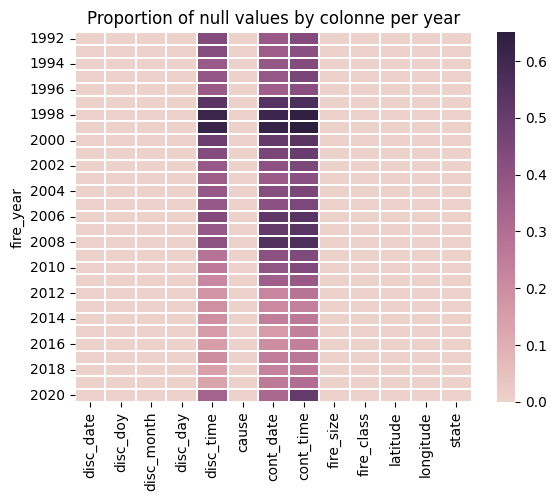

In [6]:
# Force blanks to be NA
df.disc_time.replace('',None, inplace = True)
df.cont_time.replace('',None, inplace = True)

# Print Heatmap of Missing values 
na_proportions = df.groupby('fire_year').apply(lambda group: 1 - group.drop('fire_year', axis=1).notnull().mean())
ax = sns.heatmap(na_proportions, linewidth=.1, cmap=sns.cubehelix_palette(as_cmap=True));
plt.title('Proportion of null values by colonne per year');

- Date/time information for at the moment when wildfires have been contained is missing all along the study period.
- We can note that disc_time and cont_time are not numeric data. Let's check if all values stored as str in 'disc_time' and 'cont_time' are correct.

In [7]:
# Check format of values in disc_time and cont_time columns
for time in ['disc_time', 'cont_time']:
    print('All values in', time ,'are correct:', (('0000' <= df[time]) & ('2359' >= df[time]) \
                                         & (df[time].str.len() == 4)).sum() == df.shape[0])

All values in disc_time are correct: False
All values in cont_time are correct: False


In [8]:
# Visual inspection
df.loc[df['cont_time'].str.len() !=4]

,fire_year,disc_date,disc_doy,disc_month,disc_day,disc_time,cause,cont_date,cont_time,fire_size,fire_class,latitude,longitude,state
id,,,,,,,,,,,,,,
85,2005,2005-07-04,185,7,Monday,0530,Fireworks,NaT,None,0.3,B,48.228056,-115.480278,MT
1507,2005,2005-03-11,70,3,Friday,1400,Recreation and ceremony,NaT,None,0.1,A,37.029722,-92.125556,MO
1508,2005,2005-03-11,70,3,Friday,1720,Arson/incendiarism,NaT,None,0.1,A,36.829722,-92.074167,MO
1553,2005,2005-03-15,74,3,Tuesday,1400,Debris and open burning,NaT,None,0.5,B,36.671944,-92.599722,MO
1556,2005,2005-03-16,75,3,Wednesday,1330,Arson/incendiarism,NaT,None,0.5,B,36.903889,-92.980556,MO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2303559,2019,2019-08-09,221,8,Friday,2134,Natural,NaT,None,9668.0,G,44.285050,-118.459800,OR
2303561,2020,2020-05-13,134,5,Wednesday,1300,Missing data/not specified/undetermined,NaT,None,1000.0,F,26.191111,-81.523889,FL
2303562,2020,2020-06-05,157,6,Friday,1741,Natural,NaT,None,1.0,B,39.037890,-108.959500,CO


In [9]:
df_check = df.dropna()

# Create a new df to verify that all uncorrect values are NA
for time in ['disc_time', 'cont_time']:
    print('All values in', time ,'are correct:', (('0000' <= df_check[time]) & ('2359' >= df_check[time]) \
                                         & (df_check[time].str.len() == 4)).sum() == df_check.shape[0])

display(df.isna().sum())
del(df_check)

All values in disc_time are correct: True
All values in cont_time are correct: True


fire_year          0
disc_date          0
disc_doy           0
disc_month         0
disc_day           0
disc_time     789095
cause              0
cont_date     894813
cont_time     990880
fire_size          0
fire_class         0
latitude           0
longitude          0
state              0
dtype: int64

In [10]:
# List of unique values for causes
df.cause.unique()

array(['Power generation/transmission/distribution', 'Natural',
       'Debris and open burning',
       'Missing data/not specified/undetermined',
       'Recreation and ceremony', 'Equipment and vehicle use',
       'Arson/incendiarism', 'Fireworks', 'Other causes',
       'Railroad operations and maintenance', 'Smoking',
       'Misuse of fire by a minor', 'Firearms and explosives use'],
      dtype=object)

The causes of wildfires causes are very specific, let's define more global categories so we can have different level of analysis.

In [11]:
# Dict for mapping
map_cause = {'Power generation/transmission/distribution':'Accidental',
            'Natural':'Natural',
            'Debris and open burning':'Accidental',
            'Missing data/not specified/undetermined':'Undefined',
            'Recreation and ceremony':'Accidental',
            'Equipment and vehicle use':'Accidental',
            'Arson/incendiarism':'Criminal',
            'Fireworks':'Accidental',
            'Other causes':'Accidental',
            'Railroad operations and maintenance':'Accidental',
            'Smoking':'Accidental',
            'Misuse of fire by a minor':'Accidental',
            'Firearms and explosives use':'Accidental'}

df['origin'] = df['cause'].map(map_cause)

df.head()

,fire_year,disc_date,disc_doy,disc_month,disc_day,disc_time,cause,cont_date,cont_time,fire_size,fire_class,latitude,longitude,state,origin
id,,,,,,,,,,,,,,,
1,2005,2005-02-02,33,2,Wednesday,1300,Power generation/transmission/distribution,2005-02-02,1730,0.10,A,40.036944,-121.005833,CA,Accidental
2,2004,2004-05-12,133,5,Wednesday,0845,Natural,2004-05-12,1530,0.25,A,38.933056,-120.404444,CA,Natural
3,2004,2004-05-31,152,5,Monday,1921,Debris and open burning,2004-05-31,2024,0.10,A,38.984167,-120.735556,CA,Accidental
4,2004,2004-06-28,180,6,Monday,1600,Natural,2004-07-03,1400,0.10,A,38.559167,-119.913333,CA,Natural
5,2004,2004-06-28,180,6,Monday,1600,Natural,2004-07-03,1200,0.10,A,38.559167,-119.933056,CA,Natural


We could determine the precisely the duration of wildfires using disc_time and cont_time data, however these calculations increase largely the size of the dataframe. For the rest of the analysis, we will therefore calculate a approximative duration using disc_date and cont_date. If you are interested, please find below the way to calculate wildfire duration in minutes.

In [12]:
# col = ['disc_date','disc_time', 'cont_date', 'cont_time']

# df_duration = df[col].dropna()

# def get_full_date_time(df, col_date, col_time):
#     date_time = pd.to_datetime(df[col_date].astype(str) + ' ' + df[col_time].str[:2] + ':' + \
#                               df[col_time].str[2:], format = '%Y-%m-%d %H:%M')
#     return date_time


# df_duration['full_date_start'] = get_full_date_time(df_duration, 'disc_date', 'disc_time')
# df_duration['full_date_end'] = get_full_date_time(df_duration, 'cont_date', 'cont_time')

# df_duration['duration'] = pd.to_timedelta(df_duration['full_date_end'] - \
#                                   df_duration['full_date_start'])#.dt.total_seconds().div(60).astype(int)

# df = pd.merge(df, df_duration, how = 'left').drop(['disc_time', 'cont_time', 'full_date_start', 'full_date_end'], axis = 1)

In [13]:
# Delete disc_time and cont_time columns
df.drop(['disc_time', 'cont_time'], axis = 1, inplace = True)

df.head()

,fire_year,disc_date,disc_doy,disc_month,disc_day,cause,cont_date,fire_size,fire_class,latitude,longitude,state,origin
id,,,,,,,,,,,,,
1,2005,2005-02-02,33,2,Wednesday,Power generation/transmission/distribution,2005-02-02,0.10,A,40.036944,-121.005833,CA,Accidental
2,2004,2004-05-12,133,5,Wednesday,Natural,2004-05-12,0.25,A,38.933056,-120.404444,CA,Natural
3,2004,2004-05-31,152,5,Monday,Debris and open burning,2004-05-31,0.10,A,38.984167,-120.735556,CA,Accidental
4,2004,2004-06-28,180,6,Monday,Natural,2004-07-03,0.10,A,38.559167,-119.913333,CA,Natural
5,2004,2004-06-28,180,6,Monday,Natural,2004-07-03,0.10,A,38.559167,-119.933056,CA,Natural
